In [34]:
from sed2.processes import sed_process_registry
from sed2.core import (
    serialize_instance, generate_script, ports, annotate, register, 
    register_functions, generate_composite_process, get_process_schema, 
    get_processes_and_states_from_schema, topological_sort
)
from bigraph_viz import plot_bigraph, plot_flow, pf
import numpy as np

# add sed processes to global namespace
sed_process_registry.activate_all(globals())
# print(pf(sed_process_registry.registry))

In [51]:
def register(registry):
    def decorator(func):
        registry.register(func)
        return func
    return decorator


In [13]:
@register(sed_process_registry)
@ports({
    'outputs': {
        'value': 'float'}})
@annotate('sed:loop')
def random_number():
    return random.random()

# add sed processes to global namespace
# print(pf(process_registry.registry))

In [55]:
class Process:
    
    def __init__(self, schema, process_registry=None):
        self.initialize(schema)
        
    def initialize(self, schema):
        self.schema = schema
        
    def ports(self):
        return {}
    
    def update(self, state):
        return {}
    
    
class Composite(Process):
    
    def __init__(self, schema, process_registry):
        self.initialize(schema, process_registry)
        
    def initialize(self, schema, process_registry):
        self.schema = schema
        self.process_registry = process_registry
        
        # separate the processes and states
        self.processes, self.states = get_processes_and_states_from_schema(
            self.schema, self.process_registry)
        self.sorted_processes = topological_sort(self.processes)
    
    def to_json(self):
        return serialize_instance(self.schema)
    
    def run(self):
        return {}
    

In [56]:
@register(sed_process_registry)
@ports({
    'inputs': {
        'trials': 'int',
    },
    'outputs': {
        'results': 'list'}})
@annotate('sed:range_iterator')
class RangeIterator(Composite):
    def run(self, trials):
        results = []
        for i in range(trials):
            pass
            
        return results
    
    
    
instance2 = {
    'trials': 10,
    'run': False,
    'loop': {
        '_type': 'sed:range_iterator',
        'wires': {
            'trials': 'trials',
        },
        'value': 0,
        'added': 1,
        'add': {
            '_type': 'math:add',
            'wires': {
                'a': 'value',
                'b': 'added',
                'result': 'value',
            },
        }
    },

}

# fill(instance)  # autocomplete
# validate_schema(instance) # TODO -- demonstrate validation

# Serialize to JSON
json_str1 = serialize_instance(instance2)
print(json_str1)

sim_experiment = Composite(instance2, sed_process_registry)

sim_experiment.run()

json_str = sim_experiment.to_json()
print(pf(json_str))

{"trials": 10, "run": false, "loop": {"_type": "sed:range_iterator", "wires": {"trials": "trials"}, "value": 0, "added": 1, "add": {"_type": "math:add", "wires": {"a": "value", "b": "added", "result": "value"}}}}
('{"trials": 10, "run": false, "loop": {"_type": "sed:range_iterator", '
 '"wires": {"trials": "trials"}, "value": 0, "added": 1, "add": {"_type": '
 '"math:add", "wires": {"a": "value", "b": "added", "result": "value"}}}}')


In [ ]:
# # Generate the script
# script = generate_script(json_str1, sed_process_registry)
# print(script)

# # execute the script
# exec(script)

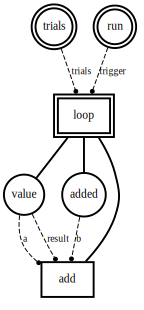

In [47]:
plot_bigraph(instance2)

## Infix

In [ ]:
import numpy as np
import re

def infix_to_postfix(infix_expression):
    precedence = {'+':1, '-':1, '*':2, '/':2, '^':3}
    right_associative = {'^'}
    stack = [] 
    postfix = []
    
    # Tokenizing the infix expression
    tokens = re.findall(r"[\w.]+|[^ \w]", infix_expression)

    for token in tokens:
        if re.match(r"^[\d.]+$", token):  # If the token is a number (integer or float)
            postfix.append(token)
        elif token.startswith('np'):  # If the token is a numpy array
            postfix.append(token)
        elif token == '(':
            stack.append('(')
        elif token == ')':
            while stack and stack[-1] != '(':
                postfix.append(stack.pop())
            if stack:
                stack.pop()
        else:  # If the token is an operator
            while (stack and stack[-1] != '(' and 
                   ((token not in right_associative and precedence.get(token, 0) <= precedence.get(stack[-1], 0)) or
                   (token in right_associative and precedence.get(token, 0) < precedence.get(stack[-1], 0)))):
                postfix.append(stack.pop())
            stack.append(token)

    while stack:
        postfix.append(stack.pop())

    postfix_expression = " ".join(postfix)
    print(f"Postfix Expression: {postfix_expression}")  # Debugging print statement
    return postfix_expression

def evaluate_postfix(postfix_expression):
    stack = []
    tokens = postfix_expression.split()

    for token in tokens:
        if re.match(r"^[\d.]+$", token):  # If the token is a number (integer or float)
            stack.append(float(token))
        elif token.startswith('np'):  # If the token is a numpy array
            stack.append(eval(token))
        else:  # If the token is an operator
            val1 = stack.pop()
            val2 = stack.pop()
            switcher = {
                '+': val2 + val1,
                '-': val2 - val1,
                '*': val2 * val1,
                '/': val2 / val1,
                '^': val2**val1
            }
            stack.append(switcher.get(token))
    
    print(f"Final Stack: {stack}")  # Debugging print statement
    return stack[0]

def evaluate_infix(infix_expression):
    postfix_expression = infix_to_postfix(infix_expression)
    result = evaluate_postfix(postfix_expression)
    return result


In [ ]:
# # Test the function
# arr1 = np.array([1, 2, 3])
# arr2 = np.array([4, 5, 6])
# print(stringify_array(arr1))  # Output: "array0"
# print(stringify_array(arr2))  # Output: "array1"

# print(evaluate_infix("(22.112+3.123)*0.245^3.1"))